# Clustering - Grupo 03

## **Authors**

- César López Mantecón - 100472092
- Manuel Gómez-Plana Rodríguez - 100472310



## **Repositorio**

Esta práctica se ha llevado a cabo en este [repositorio de github](https://github.com/ManuGPR/AA_P2_G03.git)

## **Introducción**

En este cuaderno se resolverá un problema de clustering usando un dataset de estrellas.

# Carga de dataset

## Carga del dataset por drive

In [110]:
# Para ejecutar el cuaderno en drive
#from google.colab import drive
#import pandas as pd

#drive.mount('/content/drive')
#stars = pd.read_csv("/content/drive/MyDrive/stars_data.csv") # acceder al csv en drive

## Carga del dataset en local

In [111]:
import pandas as pd
stars = pd.read_csv("stars_data.csv")

# 1. Descripción del dataset
Como podemos ver en la salida del código, contamos con un dataset de 240 instancias y 6 características. De estas 6 características, 4 son numéricas y 2 son categóricas.

In [112]:
stars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     240 non-null    int64  
 1   L               240 non-null    float64
 2   R               240 non-null    float64
 3   A_M             240 non-null    float64
 4   Color           240 non-null    object 
 5   Spectral_Class  240 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 11.4+ KB


# 2. Programación de K-Means
En este apartado, se cubre una implementación propia del algoritmo K-Means, el cuál compararemos luego con el algoritmo de `scikit-learn`.

Empty DataFrame
Columns: [Temperature, L]
Index: []
   Temperature         L
0       3749.0  550000.0
1       4287.0  630000.0
2      23440.0  537430.0
3       9892.0  593900.0
4      21738.0  748890.0
5      32489.0  648430.0
6      21904.0  748490.0
7       8829.0  537493.0
   Temperature         L
0       3749.0  550000.0
1       4287.0  630000.0
2      23440.0  537430.0
3       9892.0  593900.0
4      21738.0  748890.0
5      32489.0  648430.0
6      21904.0  748490.0
7       8829.0  537493.0
    Temperature         L
0        3749.0  550000.0
1        3660.0  363000.0
2       24630.0  363000.0
3       33421.0  352000.0
4       12675.0  452000.0
5        9373.0  424520.0
6        4287.0  630000.0
7       23440.0  537430.0
8        9892.0  593900.0
9       24145.0  382993.0
10      32489.0  648430.0
11      38940.0  374830.0
12       8829.0  537493.0
13       9235.0  404940.0
    Temperature         L
0        3749.0  550000.0
1        3660.0  363000.0
2       24630.0  363000.0
3   

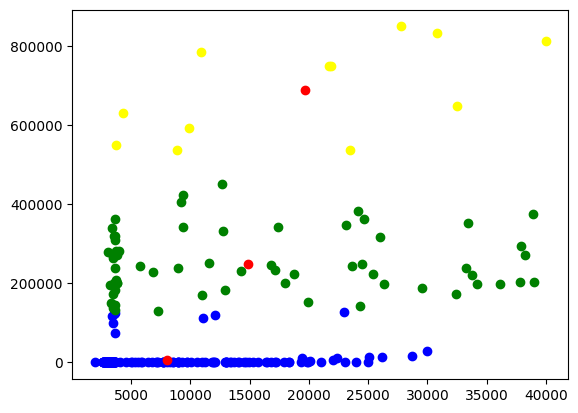

In [113]:
from random import random
from math import sqrt
import matplotlib.pyplot as plt
import numpy

class MyK_Means:
  def __init__(self, k: int, data: pd.DataFrame):
    # Número de clusters
    self.k = k

    # Datos sobre los que trabajar
    self.data = data

    # Lista con centroides, index del centroide = value del centroide
    self.centroids = []

    # Lista con los clusters, index del centroide = lista con instancias de esos clusters
    self.past_clusters = []
    self.clusters = []

    self.init_cluster()
    self.init_centroid()

  def init_cluster(self):
    for key in range(self.k):
      self.clusters.append(pd.DataFrame(columns=self.data.columns))

  def init_centroid(self):
    list_min = self.data.min().to_list()
    list_max = self.data.max().to_list()

    for key in range(self.k):
      centroid_list = []
      for column in range(len(self.data.columns)):
        centroid_list.append(random()*(list_max[column] - list_min[column]) + list_min[column])
      self.centroids.append(tuple(centroid_list))

  def calculate_closest_centroid(self, row):
    distances_cluster = []
    for key in range(len(self.centroids)):
      distances_cluster.append((self.calc_distance(self.centroids[key], row)))
    return distances_cluster.index(min(distances_cluster))

  def fit(self):
    it = 0
    while (True):
      it += 1
      self.past_clusters = []
      for n in range (self.k):
        self.past_clusters.append(self.clusters[n].copy(deep=True))
      self.clusters = []
      self.init_cluster()
      for row in range(len(self.data)):
        closest_centroid = self.calculate_closest_centroid(self.data.iloc[row, :])
        self.clusters[closest_centroid].loc[len(self.clusters[closest_centroid])] = self.data.iloc[row, :]
      self.recalculate_centroids()

      if (self.check_variation()):
        return it



  @staticmethod
  def calc_distance(vec1, vec2):
    return numpy.linalg.norm(vec1-vec2)

  def recalculate_centroids(self):
    self.centroids = []
    for index in range(len(self.clusters)):
      self.centroids.append(self.clusters[index].mean())

  def check_variation(self):
    for i in range(self.k):
      if not self.clusters[i].equals(self.past_clusters[i]):
        return False
    return True





a = MyK_Means(3, stars.iloc[0:, 0:2])
print("iteraciones: ", a.fit())

plt.scatter(a.clusters[0].iloc[0: , 0], a.clusters[0].iloc[0:, 1], color="yellow", label="datos")
plt.scatter(a.clusters[1].iloc[0: , 0], a.clusters[1].iloc[0:, 1], color="blue", label="datos")
plt.scatter(a.clusters[2].iloc[0: , 0], a.clusters[2].iloc[0:, 1], color="green", label="datos")

plt.scatter(*zip(*a.centroids), color="red", label="destacados")
plt.show()
